# Problem Description and Introduction

This project is in response to a Kaggle competition found here: https://www.kaggle.com/competitions/gan-getting-started/overview , whereby users are challenged to use GAN (Generative Adversarial Networks) to create a set of 7000-10000 images in the style of Monet to demonstrate their knowledge of this Deep Learning tool.

A General Adversarial Network is a framework used in deep learning, comprised of two neural networks: A Generator and a Discriminator. The Genererator created fake data (images in this case), while the Discriminator judges whether the data is real or fake. These two neural networks work in tandem with each other, each gaining feedback from each other to increase the efficacy of the data output. This process is iterated over continually until the data generated is realistic enought that the discriminator cant distinguish between real and fake data.

The data in this competition is two-fold: 1. A set of Monet paintings and 2. A set of Photos that users are challenged to emmulate in the style Monet.

It should be noted though, that the Kaggle Competition also specifies that users may decided to create their own images from scratch, rather than use the photos provided to be transformed in the likeness of Monet-Style paintings.

As per the competition description:

"Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos."

**This project will take the route of generating new images in the style of the Monet paintings, use DCGAN, rather than transforming the existing photos to Monet-style images.** DCGAN is an extension of GAN methodology that utilizes convulutional layers in model architecture, and is more suited for image data such as what is provided in this project.



## Library Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras import callbacks
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
import cv2
from glob import glob
import time
import math
import zipfile
from PIL import Image

# Data Load and Ingestion


As mentioned previously, the data used in this project conists of two different sets of images.

The first image set are Monet paintings, a set of 300, provided in JPEG and TFREC form. Each image is 256x256 in size.

The second set are general photogrophy imagery, a set of 7028, provided in JPEC and TFREC form. Each image is 256x256 in size.

As this project will use DCGAN to create its own photos in the style of Monet, rather than transforming existing photos, the second set of general photogrophy will not be incorporated into modelling. That said, it is still loaded into the data pipeline below and EDA is still performed on both sets of data.

The JPEG dataset will be used in this project, rather than the TFREC set.

The below code takes the data, loaded into google drive, unzips it, and loads it for use.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!mkdir -p data
!unzip '/content/drive/MyDrive/GANProject/gan-getting-started.zip' -d data

In [4]:
!ls data

monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


## Batch Loader and Initial Pre-processing

Starting this initial data pre-processing step here so some EDA can be performed. Further Pre-processing will be done after some initial EDA and data inspection, but this will occur further below

In [5]:
def imgloader(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [256, 256])
  img = (img/127.5) - 1
  return img

# EDA and Data Inspection

In [6]:
#plt.imshow(plt.imread('data/monet_jpg/000c1e3bff.jpg'))

In [7]:
#plt.imshow(plt.imread('data/photo_jpg/00882b7e1d.jpg'))

First, simply grabbing a few images from the Monet painting data to visualize what is in that dataset.

A note: One will see that this project uses a lot of visual imagery to analyse output efficacy of modeling and results. There will be some mathmatical measures of model validity, but as this is an image-based project, it is hard not to validate with an "eye-test", whereby one looks at the image outputted and judges whether or not it looks as it should or not.

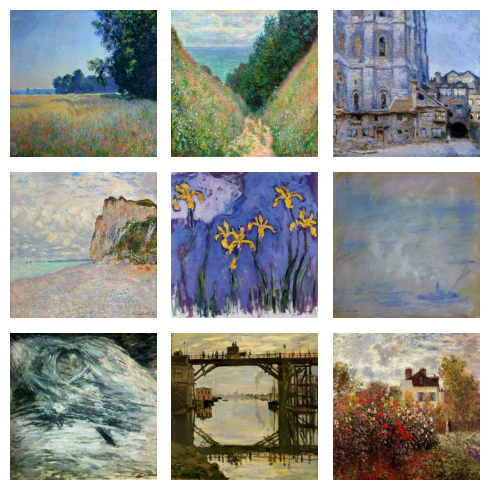

In [6]:
plt.figure(figsize= (5,5))
for i in range(9):
  img = imgloader(glob('data/monet_jpg/*.jpg')[i])
  img = (img + 1)/2
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')
plt.tight_layout()
plt.show()

Now viewing a subset of the phototography imagery provided.

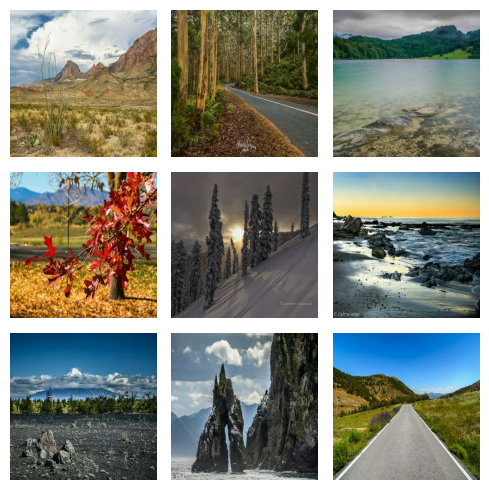

In [7]:
plt.figure(figsize= (5,5))
for i in range(9):
  img = imgloader(glob('data/photo_jpg/*.jpg')[i])
  img = (img + 1)/2
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')
plt.tight_layout()
plt.show()

(array([26040., 17433., 17729., 17785., 22076., 27127., 36653.,  8702.,
        10581., 12482.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.90000004,
        1.        ]),
 <BarContainer object of 10 artists>)

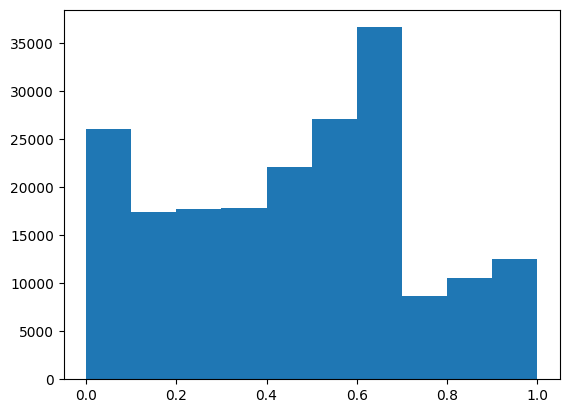

In [8]:
plt.hist(img.numpy().flatten())

The below plot simply compares the count of the images provided in the Monet set vs. the photography imagery set. As one can see, there is an imbalance (300 in the Monet-sytle paintings set, and ~7000 in the photography imagery set).

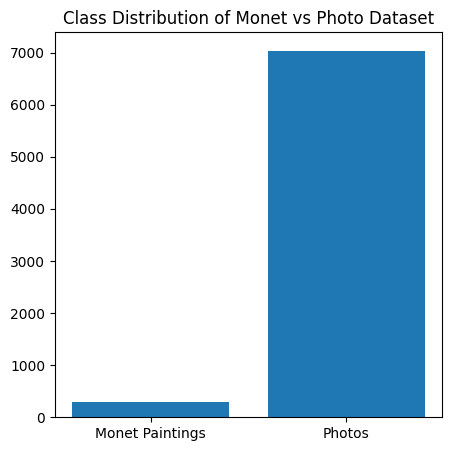

In [9]:
plt.figure(figsize= (5,5))
plt.bar(['Monet Paintings', 'Photos'], [len(glob('data/monet_jpg/*.jpg')), len(glob('data/photo_jpg/*.jpg'))])
plt.title('Class Distribution of Monet vs Photo Dataset')
plt.show()

The below code blocks provide RGB stats for the datasets provided, and then plots them as a bar-chart, comparing the RGB stats for the photo dataset and the Monet painting dataset.

In [10]:
def rgb(img_path, samp_size = 30):
  samp = img_path[:samp_size]
  mean = []
  std = []
  for i in samp:
    img = plt.imread(i)
    img = img.astype(np.float32)/255
    mean.append(np.mean(img, axis = (0,1)))
    std.append(np.std(img, axis = (0,1)))
  mean = np.array(mean)
  std = np.array(std)
  return np.mean(mean, axis = 0), np.mean(std, axis = 0)

monet_m, monet_s = rgb(glob('data/monet_jpg/*.jpg'))
photo_m, photo_s = rgb(glob('data/photo_jpg/*.jpg'))

print('Monet Mean RGB:' , monet_m)
print('Monet Std RGB:' , monet_s)
print('Photo Mean RGB:' , photo_m)
print('Photo Std RGB:' , photo_s)

Monet Mean RGB: [0.53270894 0.5161231  0.48357487]
Monet Std RGB: [0.18486188 0.17445232 0.18645856]
Photo Mean RGB: [0.44058663 0.47089136 0.472697  ]
Photo Std RGB: [0.22104077 0.20365281 0.24035479]


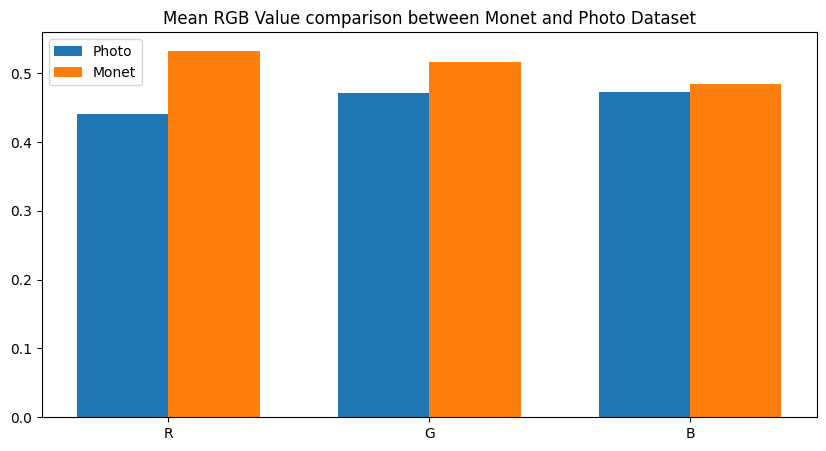

In [11]:
x = np.arange(len(['R', 'G', 'B']))

fig, ax = plt.subplots( figsize = (10,5))
r1 = ax.bar( x - 0.35/2, photo_m, 0.35, label = 'Photo')
r2 = ax.bar( x + 0.35/2, monet_m, 0.35, label = 'Monet')
ax.set_title('Mean RGB Value comparison between Monet and Photo Dataset')
ax.set_xticks(x)
ax.set_xticklabels(['R', 'G', 'B'])
ax.legend()
plt.legend()
plt.show()

## Further Data Pre-Processing

Moving on to some additional data pre-processing below. The below code block takes the full dataset and samples it to a more managable size. The reason this is done is for model expiramentation. Prior to full model runs, when experimenting with different model architectures, I would use this sampled dataset to reduce computational expense (and general runtime). As this project requires a GPU, and is relatively computationally expensive, this technique allows one to tinker with the models without taking too much time.

It should be noted that the final model runs are done on the **full dataset.** The sampled datasets were only created for personal experimentation

In [6]:
monet_data = sorted(glob('data/monet_jpg/*.jpg'))
photo_data = sorted(glob('data/photo_jpg/*.jpg'))

def data_split(monet_data, photo_data, monetn = 100, photon = 500, seed = 42):
  rng = np.random.default_rng(seed)

  monet_d = np.array(monet_data)
  photo_d = np.array(photo_data)

  monet_samp = rng.choice(monet_d, size = min(monetn, len(monet_d)) , replace = False)
  photo_samp = rng.choice(photo_d, size = min(photon, len(photo_d)), replace = False)
  return list(monet_samp), list(photo_samp)

monet_samp_data, photo_samp_data = data_split(monet_data, photo_data, monetn = 100, photon = 500)


The below functions continue the data-preprocessing steps. The jitter function is a form of data augmentation. It slighty changes the training data so that the the DCGAN model is not overfitted.

Additionaly, one can see that full train and test sets are created, alongside sampled train and test sets. The sampled datasets were created specifically for experimentation, prior to final model runs, as previously mentioned. The use of a train and test was because this project initially experimented with using CycleGAN (which utilized a train and test set), but as you will see later on in the modeling, only the train set is used. This is because I decided a DCGAN would be better suited for this specific project, and DCGAN only needs a Train set.

In [7]:
def jitter(img):
  img = tf.image.resize(img, [286, 286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = tf.image.random_crop(img, size = [256, 256, 3])
  img = tf.image.random_flip_left_right(img)
  return img

def imgloader_train(path):
  img = imgloader(path)
  img = jitter(img)
  return img

def imgloader_test(path):
  img = imgloader(path)
  return img


In [8]:
#Full Dataset for final run
monet_train = (tf.data.Dataset.from_tensor_slices(monet_data).shuffle(buffer_size = len(monet_data))
            .map(imgloader_train, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))

photo_train = (tf.data.Dataset.from_tensor_slices(photo_data).shuffle(buffer_size = len(photo_data))
            .map(imgloader_train, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))


monet_test = (tf.data.Dataset.from_tensor_slices(monet_data)
            .map(imgloader_test, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))

photo_test = (tf.data.Dataset.from_tensor_slices(photo_data)
            .map(imgloader_test, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))

#Sampled Dataset for experimentation
monet_train_samp = (tf.data.Dataset.from_tensor_slices(monet_samp_data).shuffle(buffer_size = len(monet_samp_data))
            .map(imgloader_train, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))

photo_train_samp = (tf.data.Dataset.from_tensor_slices(photo_samp_data).shuffle(buffer_size = len(photo_samp_data))
            .map(imgloader_train, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))


monet_test_samp = (tf.data.Dataset.from_tensor_slices(monet_samp_data)
            .map(imgloader_test, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))

photo_test_samp = (tf.data.Dataset.from_tensor_slices(photo_samp_data)
            .map(imgloader_test, num_parallel_calls = tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE))




Now showing an example of the pre-processed images put in place with jitter function completed.

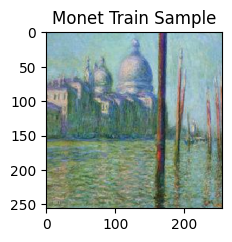

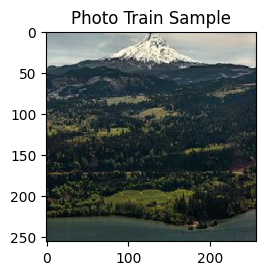

In [17]:
sampm = next(iter(monet_train_samp))
sampp = next(iter(photo_train_samp))

plt.figure(figsize = (5,5))
plt.subplot(1,2,1)
plt.title('Monet Train Sample')
plt.imshow((sampm[0] + 1)/2)

plt.figure(figsize = (5,5))
plt.subplot(1,2,1)
plt.title('Photo Train Sample')
plt.imshow((sampp[0] + 1)/2)

plt.tight_layout()
plt.show()

# Model 0: Baseline DCGAN Model

A baseline DCGAN model is created below, a simple initial run through the full dataset to see where areas of improvement and be made and what parameters might be tuned in the hyperparamater tuning step.

## Model 0 Architecture

The baseline model architecture is a very simple DCGAN. It consists of a generator and discriminator function with the images as input (256x256x3) and latent spaces as 100.

For the generator:
There is a dense layer (16x16x256), with multiple blocks below (upsampling) that perform a Conv2d transpose and ReLu activations. It then outputs a 256x256x3 image

For the discriminator:
There are multiple downsampling blocks that perform a Conv2d transpose and leaky Reu activations. There is then an output logit score to feed back into the generator for feedback on image realness vs fakeness.

In [18]:
def generator_arch():
  inputs = layers.Input(shape = (100,))

  x = layers.Dense(16*16*256)(inputs)
  x = layers.Reshape((16,16,256))(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same')(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(64, 4, strides = 2, padding = 'same')(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(32, 4, strides = 2, padding = 'same')(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(16, 4, strides = 2, padding = 'same')(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(3,3, padding = 'same', activation = 'tanh')(x)
  return keras.Model(inputs, x, name = 'generator')

def discriminator_arch():
  inputs = layers.Input(shape = (256,256,3))

  x = layers.Conv2D(64, 4, strides = 2, padding = 'same')(inputs)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(128, 4, strides = 2, padding = 'same')(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(256, 4, strides = 2, padding = 'same')(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(512, 4, strides = 2, padding = 'same')(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1)(x)

  return keras.Model(inputs, x, name = 'discriminator')

generator = generator_arch()
discriminator = discriminator_arch()

generator.summary()
discriminator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 65536)          │     6,619,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 16)   │         8,208 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 256, 3)    │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,316,131 (27.91 MB)

 Trainable params: 7,316,131 (27.91 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,887,617 (11.02 MB)

 Trainable params: 2,887,617 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

An additional step after defining the architecture is setting up for training. Here an Adam optimizer is used for the discriminator and generator, with learning rate of 2e-4. Loss is definied by binary cross entropy. Both of these will be called upon in the training fucntion

In [19]:
lr = 2e-4

bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)

gen_optimizer = keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.5)
disc_optimizer = keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.5)

## Training Function

The training function uses TensorFlow training, to perform the DCGAN. It takes the architecture and training steps defined above and pulls them in with the end goal of using the discriminator to score the discriminator to score the fake images, and the generator to take feedback and make more monet-like images.

In [20]:
@tf.function
def train_baseline(real_image):
  batch = tf.shape(real_image)[0]
  noise = tf.random.normal(shape = (batch, 100))
  with tf.GradientTape(persistent = True) as tape:
    fake_image = generator(noise, training = True)

    real_logits = discriminator(real_image, training = True)
    fake_logits = discriminator(fake_image, training = True)

    disc_real = bce(tf.ones_like(real_logits), real_logits)
    disc_fake = bce(tf.zeros_like(fake_logits), fake_logits)
    disc_loss = (disc_real + disc_fake)* 0.5

    gen_loss = bce(tf.ones_like(fake_logits), fake_logits)

  gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  return gen_loss, disc_loss


The below code calls the training function and trains the model over 30 epochs, capturing gen loss, discriminator loss, and the overall time it takes for each step.

In [2]:
for epoch in range(1, 30+1):
  start = time.time()
  gen_total_epoch = 0
  disc_total_epoch = 0

  step = 0

  for real_batch in monet_train:
    gen_loss, disc_loss = train_baseline(real_batch)
    step += 1
    gen_total_epoch += float(gen_loss)
    disc_total_epoch += float(disc_loss)

    print(f'Epoch {epoch}/{30}', f'Gen = {gen_total_epoch/step}', f'Disc = {disc_total_epoch/step}',
          'time =' , time.time() - start)

# Model 0 Results and Analysis

Looking at a sample of the baseline model results below, one can see there are some similariities in colors to the monet images, but it is certainly not perfect. The texture is far from what a monet painting looks like and it does seem to be overstating blues and greens.

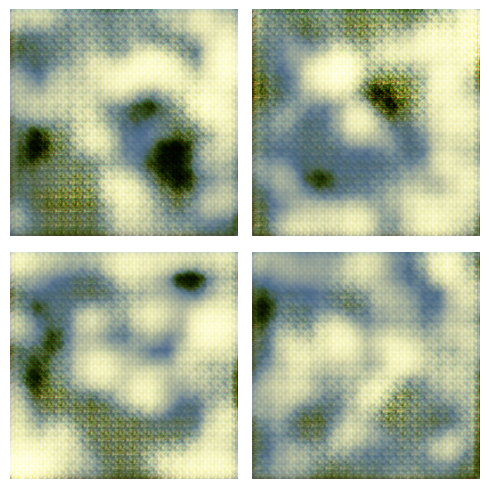

In [22]:
def show_samps (n = 4):
  noise = tf.random.normal([n,100])
  fake = generator(noise, training = False)
  fake = (fake + 1)/2

  plt.figure(figsize = (5,5))
  for i in range(n):
    plt.subplot(2,2,i+1)
    plt.imshow(fake[i])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

show_samps(4)

# Models 1-3: Updated Architecture and Hyperparamater Tuning on DCGAN

For the next run I performed beow, two important updates were made before proceding. The first update that was made was to the models' architecture (which will be described below), and the second is the use of hyperparamater tuning loss rate and label smoothing. This resulted in three distinct model runs, which will be shown below.

## Models 1-3 Architecture

The architecture for models 1-3 is an upgrade from the simple DCGAN used in the baseline model.

Similar to the baseline model, it consists of a generator and discriminator function with the images as input (256x256x3) and latent spaces as 100.

Where it differs is in the use of batch normalization at each downsampling and upsamplinng block. Additionally, instead of 4 blocks a peice in the discriminator and generator, there are 5 blocks used.

For the generator: There is a dense layer (16x16x256), with multiple blocks below (upsampling) that perform a Conv2d transpose and ReLu activations, as well as batch normalization on each block. It then outputs a 256x256x3 image

For the discriminator: There are multiple downsampling blocks that perform a Conv2d transpose and leaky Reu activations, as well as batch normalization on each block. There is then an output logit score to feed back into the generator for feedback on image realness vs fakeness

In [10]:
def generator2_arch():
  inputs = layers.Input(shape = (100,))

  x = layers.Dense(8*8*512)(inputs)
  x = layers.Reshape((8,8,512))(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(256, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(64, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(32, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(16, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(3,3, padding = 'same', activation = 'tanh')(x)
  return keras.Model(inputs, x, name = 'generator2')

def discriminator2_arch():
  inputs = layers.Input(shape = (256,256,3))

  x = layers.Conv2D(64, 4, strides = 2, padding = 'same', use_bias = False)(inputs)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(128, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(256, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(512, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(512, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1)(x)

  return keras.Model(inputs, x, name = 'discriminator2')

generator2 = generator2_arch()
discriminator2 = discriminator2_arch()

generator2.summary()
discriminator2.summary()

Model: "generator2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 32)   │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 256, 16)   │         8,192 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,107,507 (23.30 MB)

 Trainable params: 6,105,491 (23.29 MB)

 Non-trainable params: 2,016 (7.88 KB)

Model: "discriminator2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,988,289 (26.66 MB)

 Trainable params: 6,985,473 (26.65 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Tuning Search & Tune Function

Below the code creates three separate model configurations, experimenting with loss rate, and label smoothing to identify a well performing model.

After defining these configurations, a Tune function is created, that will be called in the model training function to pass the separate model configurations through. This ultimately performs our hyperparamater tuning.

In [11]:
tune = [{'name': 'Model1', 'lr_g': 2e-4, 'lr_d': 2e-4, 'label_smooth': 1.0},
         {'name': 'Model2', 'lr_g': 2e-4, 'lr_d': 2e-4, 'label_smooth': 0.9},
         {'name': 'Model3', 'lr_g': 1e-4, 'lr_d': 2e-4, 'label_smooth': 0.9}]

In [12]:


bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def Tune(t):
  generator2 = generator2_arch()
  discriminator2 = discriminator2_arch()
  gen_optimizer2 = keras.optimizers.Adam(t['lr_g'], beta_1 = 0.5)
  disc_optimizer2 = keras.optimizers.Adam(t['lr_d'], beta_1 = 0.5)

  return generator2, discriminator2, gen_optimizer2, disc_optimizer2

## Models 1-3 Training with Hyperparameter Tuning

The training fucntion below calls upon all model architecture and tuning praramters to create the DCGAN. It takes the architecture and training steps defined above and pulls them in with the end goal of using the discriminator to score the discriminator to score the fake images, and the generator to take feedback and make more monet-like images.

In [26]:

#@tf.function
def train_tune(real_image, generator2, discriminator2, gen_optimizer2, disc_optimizer2, label_smooth):
  batch = tf.shape(real_image)[0]
  noise = tf.random.normal(shape = (batch, 100))
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    fake_image = generator2(noise, training = True)

    real_logits = discriminator2(real_image, training = True)
    fake_logits = discriminator2(fake_image, training = True)


    disc_real = bce((tf.ones_like(real_logits)* label_smooth), real_logits)
    disc_fake = bce(tf.zeros_like(fake_logits), fake_logits)
    disc_loss = (disc_real + disc_fake)* 0.5

    gen_loss = bce(tf.ones_like(fake_logits), fake_logits)

  gen_gradients = g_tape.gradient(gen_loss, generator2.trainable_variables)
  disc_gradients = d_tape.gradient(disc_loss, discriminator2.trainable_variables)

  disc_optimizer2.apply_gradients(zip(disc_gradients, discriminator2.trainable_variables))
  gen_optimizer2.apply_gradients(zip(gen_gradients, generator2.trainable_variables))
  return gen_loss, disc_loss

Finally, the step that actually initialzes the model training. The below code calls the training function and trains each separate model with the various configs over 10 epochs per model (30 in total), capturing gen loss, discriminator loss, and the overall time it takes for each step.

An additional improvement over the previous run, is that this is capturing the final results of the model, which will later be shown in results_df below.

In [3]:
results= []
for t in tune:
  print(f'Tuning {t["name"]}')
  generator2, discriminator2, gen_optimizer2, disc_optimizer2 = Tune(t)

  for epoch in range(1, 10+1):
    start = time.time()
    gen_total_epoch = 0
    disc_total_epoch = 0

    step = 0

    for real_batch in monet_train:
      gen_loss, disc_loss = train_tune(
          real_batch, generator2, discriminator2,
          gen_optimizer2, disc_optimizer2,
          label_smooth = t['label_smooth'])
      step += 1
      gen_total_epoch += float(gen_loss)
      disc_total_epoch += float(disc_loss)

      print(f'Epoch {epoch}/{10}', f'Gen = {gen_total_epoch/step}',
            f'Disc = {disc_total_epoch/step}',
            'time =' , time.time() - start)

  results.append({
      'name': t['name'],
      'lr_g': t['lr_g'],
      'lr_d': t['lr_d'],
      'label_smooth': t['label_smooth'],
      'gen_loss': gen_total_epoch/step,
      'disc_loss': disc_total_epoch/step,
      'generator': generator2, 'discriminator': discriminator2})

# Results and Analysis of Hypertuning

Now seeing the tabulated results of these three models. All of them show a generator loss and discriminator loss that is within reason, so no model collapse occured. This will not tell us the actual model output, but just ensures that model collapse has not happened and each of the models below remained stable throughout their runs.

In [28]:
results_df = pd.DataFrame(results)
results_df

name    lr_g    lr_d  label_smooth  gen_loss  disc_loss  \
0  Model1  0.0002  0.0002           1.0  3.518157   0.681983   
1  Model2  0.0002  0.0002           0.9  2.711704   0.623534   
2  Model3  0.0001  0.0002           0.9  3.466398   0.602446   

                                  generator  \
0  <Functional name=generator2, built=True>   
1  <Functional name=generator2, built=True>   
2  <Functional name=generator2, built=True>   

                                  discriminator  
0  <Functional name=discriminator2, built=True>  
1  <Functional name=discriminator2, built=True>  
2  <Functional name=discriminator2, built=True>

Finally, displaying some samples from each model below. Lets break down the visual results below:

Model 1: This model may be the strongest contender. It shows a nice variance of hues, with lots of green and blues, but still well balanced across the color spectrum. The image is still a bit blurry, but seems to be the most well suited model so far.

Model 2: This model is way oversaturated with blue hues. It seems to have hung on to that color and is not showing a lot of color variety.

Model 3: Again, this model is oversaturated with a color, this time along the red/orange spectrum. There does seem to be more depth in the balance of light and dark, but still too much focus on a thin slice of the color spectrum.

Model1


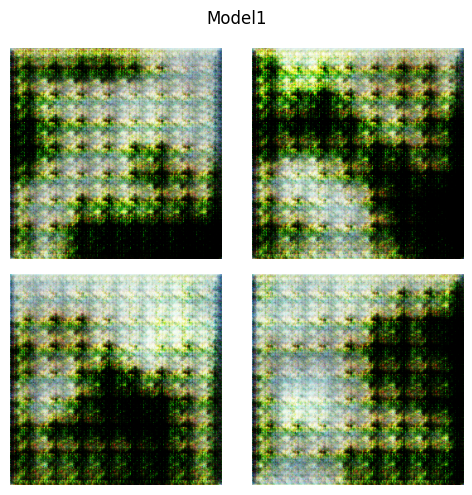

Model2


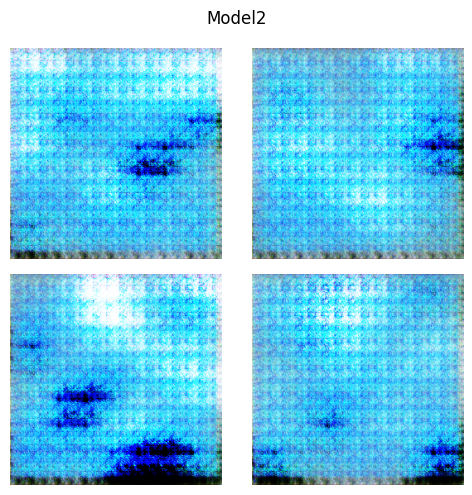

Model3


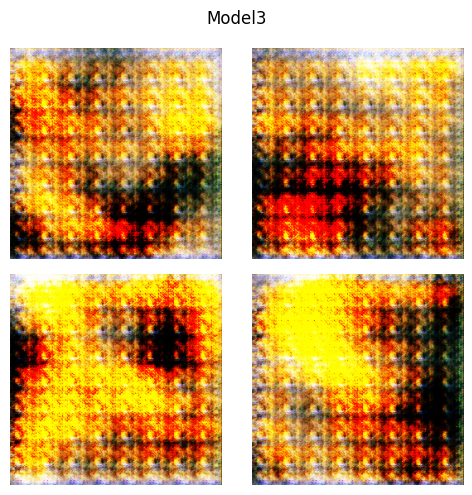

In [29]:
def show_samps2 (gen, n = 4, title =''):
  noise = tf.random.normal([n,100])
  fake = gen(noise, training = False)
  fake = (fake + 1)/2

  plt.figure(figsize = (5,5))
  for i in range(n):
    plt.subplot(2,2,i+1)
    plt.imshow(fake[i])
    plt.axis('off')
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

for r in results:
  t_name = r['name']
  print(t_name)
  show_samps2(r['generator'], n = 4, title = t_name)






# Final DCGAN Model Run with Hyperparamater Tuned Model (Model 1) through 200 epochs

Now that I ran hyperparameter tuning, I am going to select one of those models to do a 200 epoch run on, which will result in much longer training, and provide a stronger result. The model I have selected from the hyperparamater tuning is model 1. It seems to have produced the strongest result, so it will be used for my final model in the kaggle competition.

## Final Model Architecture

The architecture for this model is the same as was used in the hyperparamater tuning section. The only update in this section is selecting one model config (model 1) and training over 200 epochs, instead of 10, as was previously done.

Similar to the baseline model, it consists of a generator and discriminator function with the images as input (256x256x3) and latent spaces as 100.

Where it differs is in the use of batch normalization at each downsampling and upsamplinng block. Additionally, instead of 4 blocks a peice in the discriminator and generator, there are 5 blocks used.

For the generator: There is a dense layer (16x16x256), with multiple blocks below (upsampling) that perform a Conv2d transpose and ReLu activations, as well as batch normalization on each block. It then outputs a 256x256x3 image

For the discriminator: There are multiple downsampling blocks that perform a Conv2d transpose and leaky Reu activations, as well as batch normalization on each block. There is then an output logit score to feed back into the generator for feedback on image realness vs fakeness

In [9]:
def generator2_arch():
  inputs = layers.Input(shape = (100,))

  x = layers.Dense(8*8*512)(inputs)
  x = layers.Reshape((8,8,512))(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(256, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(64, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(32, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(16, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(3,3, padding = 'same', activation = 'tanh')(x)
  return keras.Model(inputs, x, name = 'generator2')

def discriminator2_arch():
  inputs = layers.Input(shape = (256,256,3))

  x = layers.Conv2D(64, 4, strides = 2, padding = 'same', use_bias = False)(inputs)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(128, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(256, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(512, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(512, 4, strides = 2, padding = 'same', use_bias = False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1)(x)

  return keras.Model(inputs, x, name = 'discriminator2')

generator2 = generator2_arch()
discriminator2 = discriminator2_arch()

generator2.summary()
discriminator2.summary()

Model: "generator2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 32)   │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 256, 16)   │         8,192 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,107,507 (23.30 MB)

 Trainable params: 6,105,491 (23.29 MB)

 Non-trainable params: 2,016 (7.88 KB)

Model: "discriminator2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,988,289 (26.66 MB)

 Trainable params: 6,985,473 (26.65 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [10]:
tune = [{'name': 'Model1', 'lr_g': 2e-4, 'lr_d': 2e-4, 'label_smooth': 1.0},
         {'name': 'Model2', 'lr_g': 2e-4, 'lr_d': 2e-4, 'label_smooth': 0.9},
         {'name': 'Model3', 'lr_g': 1e-4, 'lr_d': 2e-4, 'label_smooth': 0.9}]

In [11]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def Tune(t):
  generator2 = generator2_arch()
  discriminator2 = discriminator2_arch()
  gen_optimizer2 = keras.optimizers.Adam(t['lr_g'], beta_1 = 0.5)
  disc_optimizer2 = keras.optimizers.Adam(t['lr_d'], beta_1 = 0.5)

  return generator2, discriminator2, gen_optimizer2, disc_optimizer2

In [12]:
best_model = tune[0]
best_gen, best_disc, best_gen_opt, best_disc_opt = Tune(best_model)


## Final Model Training

The training fucntion below calls upon all model architecture and selects only the Model 1 training parameters to create the DCGAN. It takes the architecture and training steps defined above and pulls them in with the end goal of using the discriminator to score the discriminator to score the fake images, and the generator to take feedback and make more monet-like images.

In [13]:
@tf.function
def train_tune_final(real_image):
  batch = tf.shape(real_image)[0]
  noise = tf.random.normal(shape = (batch, 100))
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    fake_image = best_gen(noise, training = True)

    real_logits = best_disc(real_image, training = True)
    fake_logits = best_disc(fake_image, training = True)


    disc_real = bce((tf.ones_like(real_logits)* best_model['label_smooth']), real_logits)
    disc_fake = bce(tf.zeros_like(fake_logits), fake_logits)
    disc_loss = (disc_real + disc_fake)* 0.5

    gen_loss = bce(tf.ones_like(fake_logits), fake_logits)

  gen_gradients = g_tape.gradient(gen_loss, best_gen.trainable_variables)
  disc_gradients = d_tape.gradient(disc_loss, best_disc.trainable_variables)

  best_disc_opt.apply_gradients(zip(disc_gradients, best_disc.trainable_variables))
  best_gen_opt.apply_gradients(zip(gen_gradients, best_gen.trainable_variables))
  return gen_loss, disc_loss

This code block below will be what initiates the training of the final model. It calls upon the training function (which has the best model configs: model 1), and then runs through 200 epochs of training. One update to this, as compared to previous runs is storing the discriminator loss and generator loss at each epoch.

In [4]:
results3= []

for epoch in range(1, 200+1):
  start = time.time()
  gen_total_epoch = 0
  disc_total_epoch = 0

  step = 0

  for real_batch in monet_train:
    gen_loss, disc_loss = train_tune_final(real_batch)
    step += 1
    gen_total_epoch += float(gen_loss)
    disc_total_epoch += float(disc_loss)

    avg_gen = gen_total_epoch/step
    avg_disc = disc_total_epoch/step
    print(f'Epoch {epoch}/{200}', f'Gen = {avg_gen}',
          f'Disc = {avg_disc}',
          'time =' , time.time() - start)

  results3.append({
      'epoch': epoch,
      'gen_loss': avg_gen,
      'disc_loss': avg_disc})


# Final Model Results and Analysis

The below code stores the results of generator loss and discriminator loss across the epochs in a dataframe.

In [15]:
results3_df = pd.DataFrame(results3)
results3_df.head()

epoch   gen_loss  disc_loss
0      1  10.204772   0.608489
1      2   6.552024   0.791621
2      3   4.859327   0.938099
3      4   4.338893   0.988895
4      5   4.301806   0.851918

Now, displaying the generator loss and discriminator loss over all the epochs. As one can see, the model remained stable throught the whole run and did not collapse. This is a positive result, and will not show us the output of the model, but will show us that the model did not collapse.

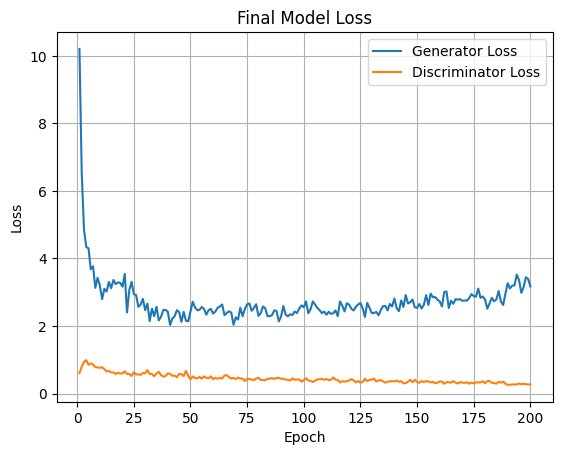

In [16]:
plt.figure()
plt.plot(results3_df['epoch'], results3_df['gen_loss'], label = 'Generator Loss')
plt.plot(results3_df['epoch'], results3_df['disc_loss'], label = 'Discriminator Loss')
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Finally viewing the resulting output of the model training. The images below are samples from the training run. As one can see, the texture of the images is much improved upon from the previous models. One can see what resembles a sky and bodies of water, brush strokes that emulate what looks like trees and the earth. This is a much stronger result for the kaggle competition.

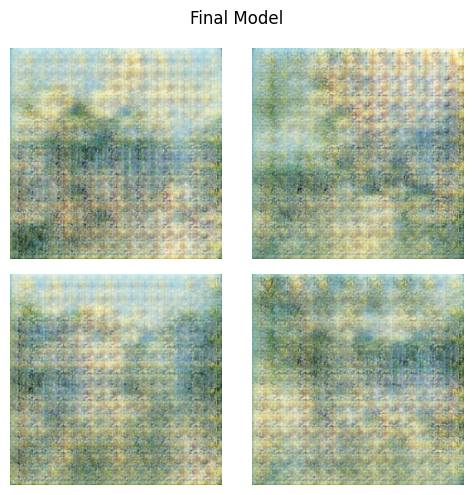

In [17]:
def show_samps3 (n = 4):
  noise = tf.random.normal([n,100])
  fake = best_gen(noise, training = False)
  fake = (fake + 1)/2

  plt.figure(figsize = (5,5))
  for i in range(n):
    plt.subplot(2,2,i+1)
    plt.imshow(fake[i])
    plt.axis('off')
  plt.suptitle('Final Model')
  plt.tight_layout()
  plt.show()

show_samps3(4)

# Discussion of Results and Conclusion

This notebook ran through three separte iterations of model runs. The first was a baseline model with a simple architecture and a limited number of epochs (30). The second was a more complex, dense architecture, with hyperparameter tuning when the models were trained, resulting in three distinct model configurations. This run ran for 30 epochs in total (with each distinct model getting 10 epochs of run time). From this second iteration, a "Best Model" was chosen for a final run. In this third and final run, the best model was run through the new, more complex architecture for a total of 200 epochs.

As is shown by the discriminator loss and gradient loss over the total epochs above, this final run remained stable and the model did not collapse. The result of this final run was the output of complex, detailed imagery that vastly improved upon the previous image outputs and provided a more monet-like image with similar texture that imitated the brush strokes of Monet. This provided a usable submission for the Kaggle competion.

Overall, this project provided an interesting look into how DCGAN can take in input images and provide an interesting result, given proper hyperparamater tuning and architecture experimentation.

One of the limitations of this project, was that DCGAN does not perform style transfer tasks, so using the image transfer from the photos to the monet style was not possible. This was okay for this kaggle competition as it explicitly stated that DCGAN was an acceptable model to use and style transfer is not necesary, but it would be interesting to see how CycleGAN could be applied to this project.

For future work, as stated, it would be interesting to use a CycleGAN to transfer the monet style to a set of predefined images, rather than having DCGAN create images itself.

# Appendix: Code Block for Kaggle Competition Submission

The below code is what I used to create the 7000 images necesary for the kaggle competition. It is not completely necesary for this notebook, but is required to run after the final model used in the kaggle competition

In [ ]:
img_count = 7000
batch = 64
outdir = 'images'

os.makedirs(outdir, exist_ok = True)

batch_num = math.ceil(img_count/batch)
idx = 0

for i in range(batch_num):
    currentidx = min(batch, img_count - idx)
    noise = tf.random.normal([currentidx, 100])
    fake = best_gen(noise, training = False)
    fake = (fake + 1)/2
    fake = tf.clip_by_value(fake, 0.0, 1.0)
    fake_num = (fake.numpy()*255).astype(np.uint8)

    for j in range(currentidx):
        img = Image.fromarray(fake_num[j])
        filen = f'{idx:05d}.jpg'
        img.save(os.path.join(outdir, filen), format = 'JPEG')
        idx +=1

print(idx, outdir)

zip_p = 'images.zip'
with zipfile.ZipFile(zip_p, 'w', compression = zipfile.ZIP_DEFLATED) as zf:
    for filen in sorted(os.listdir(outdir)):
        fpath = os.path.join(outdir, filen)
        zf.write(fpath, arcname = filen)

# Citations

[1] Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

[2] PyTorch DCGAN Tutorial
Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., … & Chintala, S. (n.d.). DCGAN tutorial: Training a generative adversarial network to generate face images. PyTorch.
https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

[3] OpenAI. (2025). ChatGPT (version GPT-5) [Large language model]. OpenAI. (Used for error trace debugging and function usage examples.)

[4] Google DeepMind. (2025). Gemini [Large language model]. Google DeepMind. (Used for error trace debugging and function usage examples.)

[5] TensorFlow DCGAN Tutorial
TensorFlow. (n.d.). Deep convolutional generative adversarial networks (DCGAN). TensorFlow Tutorials.
https://www.tensorflow.org/tutorials/generative/dcgan

[6] Weights & Biases (W&B) DCGAN Guide
Weights & Biases. (n.d.). How to implement deep convolutional generative adversarial networks (DCGAN) in TensorFlow. W&B Reports.
https://wandb.ai/generative-adversarial-networks/dcgan-tensorflow/reports/How-to-Implement-Deep-Convolutional-Generative-Adversarial-Networks-DCGAN-in-TensorFlow–VmlldzoxNzkzNDg5

[7]Usubamatov, N. (n.d.). GAN introduction. Plessons. https://pylessons.com/gan-introduction
